In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm

import utils
import importlib
importlib.reload(utils)
# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

In [45]:
df = pd.read_csv('data/prices.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df_original = df[['y3', 'y8']]
sample_df = df.iloc[:575]
test_df = df.iloc[575:]
df.head()
sample_df.tail()
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 575 entries, 2023-09-09 to 2025-04-05
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y1      575 non-null    float64
 1   y2      575 non-null    float64
 2   y3      575 non-null    float64
 3   y4      575 non-null    float64
 4   y5      575 non-null    float64
 5   y6      575 non-null    float64
 6   y7      575 non-null    float64
 7   y8      575 non-null    float64
 8   y9      575 non-null    float64
 9   y10     575 non-null    float64
dtypes: float64(10)
memory usage: 49.4 KB


In [38]:
coint_df = sample_df[['y3', 'y8']]
coint_df.tail()


,y3,y8
date,,
2025-04-01,82.2000000000,60.9000000000
2025-04-02,82.1600000000,61.0000000000
2025-04-03,81.6600000000,60.1900000000
2025-04-04,82.2800000000,60.6200000000
2025-04-05,82.9000000000,61.6800000000


In [36]:
coint_test_df = test_df[['y3', 'y8']]
coint_test_df.head()

,y3,y8
date,,
2025-04-06,82.2000000000,61.1300000000
2025-04-07,82.6900000000,61.6000000000
2025-04-08,81.5900000000,59.9200000000
2025-04-09,81.1900000000,59.1000000000
2025-04-10,81.3900000000,59.4700000000


In [4]:
# print(coint_df.dtypes)
print(coint_df.index)
coint_df = coint_df.dropna().astype(float)

DatetimeIndex(['2023-09-09', '2023-09-10', '2023-09-11', '2023-09-12',
               '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-16',
               '2023-09-17', '2023-09-18',
               ...
               '2025-03-27', '2025-03-28', '2025-03-29', '2025-03-30',
               '2025-03-31', '2025-04-01', '2025-04-02', '2025-04-03',
               '2025-04-04', '2025-04-05'],
              dtype='datetime64[ns]', name='date', length=575, freq=None)


Let's again see how both series looks on one diagram

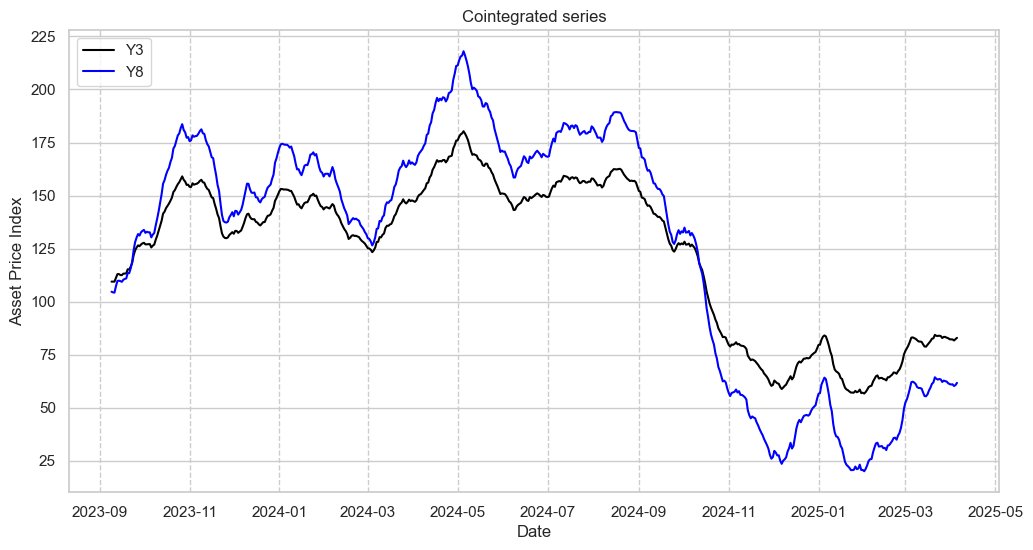

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(coint_df['y3'], label='Y3', color='black')
plt.plot(coint_df['y8'], label='Y8', color='blue')
plt.title('Cointegrated series')
plt.xlabel('Date')
plt.ylabel('Asset Price Index')
plt.legend(loc='upper left')
plt.grid(True, which='major', axis='x', linestyle='--')
plt.show()

Clearly we can observe long term relationship between those two time series, where for most of the time Y8 is above Y3, with that behaviour changing around 2024-10. In further steps we will examine this relationship more formally by running tests for cointegration.

## Cointegration Test ##

 ΔYt = ΠYt−1 + Γ1ΔYt−1 + Γ2ΔYt−2 + . . . + Γp−1ΔYt−(p−1) + εt

We would like to run Johansen Cointegration tests. But because lag length can affect this test, we should first decide how many lags will be taken into consideration. Because we are dealing with financial asset prices first what comes to mind is 5 lags. But to make more informed decision we can employ information criteria.

In [60]:
model = VAR(coint_df, freq='D')
results = model.select_order(maxlags=10)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.909       3.925       49.87       3.915
1       -2.738      -2.692     0.06470      -2.720
2       -3.244      -3.167     0.03900      -3.214
3       -3.277     -3.169*     0.03776     -3.235*
4      -3.279*      -3.141    0.03767*      -3.225
5       -3.272      -3.103     0.03793      -3.206
6       -3.267      -3.068     0.03811      -3.189
7       -3.264      -3.034     0.03824      -3.174
8       -3.260      -2.999     0.03838      -3.158
9       -3.250      -2.959     0.03876      -3.136
10      -3.240      -2.918     0.03916      -3.114
--------------------------------------------------


We are looking at lowest values for each criteria. We can see that two of the information criteria are pointing to 3 lags and two to 4. Let's use method for picking up the most optimal number of lags.

In [7]:

utils.selct_var_order(coint_df, max_lags=10)

,aic,bic,hqic,fpe
1,1,1,1,1
2,2,2,2,2
3,3,2,3,3
4,4,2,3,4
5,4,3,3,4
6,4,3,3,4
7,4,3,3,4
8,4,3,3,4
9,4,3,3,4
10,4,3,3,4


Given that we are dealing with financial instruments data we will use 3 number of lags in our test. Also AIC and FPE usually favor bigger number of lags, BIC is usually on the lower side, but HQIC should be something in between.

# Performing Johansen test

We are performing this test to verify if cointegrated vector exists for those two time series.

In [8]:
# Perform Johansen test
# K=4 in levels VAR -> k_ar_diff = K-1 = 3 lags in VECM differences
# ecdet = "const" -> det_order = 0 (constant in CE)

johansen_result = coint_johansen(sample_df[['y3', 'y8']], det_order=0, k_ar_diff=3)

print("Johansen Test Results:")
print("Eigenvalues:")
print(johansen_result.eig)
print("\nTrace Statistic:")
print(johansen_result.lr1)
print("\nCritical Values (90%, 95%, 99%) for Trace Statistic:")
print(johansen_result.cvt)
print("\nMaximum Eigenvalue Statistic:")
print(johansen_result.lr2)
print("\nCritical Values (90%, 95%, 99%) for Max Eigenvalue Statistic:")
print(johansen_result.cvm)

Johansen Test Results:
Eigenvalues:
[0.21611043 0.00174808]

Trace Statistic:
[140.03017501   0.9990293 ]

Critical Values (90%, 95%, 99%) for Trace Statistic:
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Maximum Eigenvalue Statistic:
[139.03114571   0.9990293 ]

Critical Values (90%, 95%, 99%) for Max Eigenvalue Statistic:
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [9]:
print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvt[i, 2]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 2]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1']  # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvm[i, 2]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 2]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 140.030
  Critical Value (95%): 19.935
  Result: Reject H0 at 5% significance level.
H0: r <= 1
  Trace Statistic: 0.999
  Critical Value (95%): 6.635
  Result: Cannot reject H0 at 5% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 139.031
  Critical Value (95%): 18.520
  Result: Reject H0 at 5% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 0.999
  Critical Value (95%): 6.635
  Result: Cannot reject H0 at 5% significance level.


In both cases for Trace and Max Eigenvalue tests we can see that H0 indicating that there is **no cointegrating vector can be rejected**. However, we fail to reject H0 that there is **one cointegrating vector** thus implying that we have exactly one cointegrating vector and series is cointegrated.

## VECM model ##

Following variables will be used in our VECM model
* Previously set number of lags = 4 so lag order in differences will be 3.
* Cointegration as already establish is of rank one
* Daily frequency = daily
* why ci exactly?

In [74]:
# Estimate VECM
vecm_model = VECM(coint_df, k_ar_diff=3, coint_rank=1, deterministic='ci', freq='D')
vecm_results = vecm_model.fit()

Let's see the results:

In [62]:
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y3
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y3         -0.1897      1.007     -0.188      0.851      -2.164       1.785
L1.y8          0.4210      0.628      0.671      0.502      -0.809       1.651
L2.y3         -0.2336      0.942     -0.248      0.804      -2.080       1.613
L2.y8          0.2449      0.587      0.417      0.677      -0.906       1.395
L3.y3         -0.1040      0.862     -0.121      0.904      -1.794       1.586
L3.y8          0.1050      0.537      0.195      0.845      -0.948       1.158
L4.y3         -0.0984      0.776     -0.127      0.899      -1.620       1.423
L4.y8          0.1242      0.484      0.256      0.798      -0.825       1.074
L5.y3         -0.0148      0.688     -0.021      0.983      -1.363       1.334
L5.y8          0.0032      0.429      0.007      

The VECM is given by:

$$\Delta\boldsymbol{y}_t = \Pi\boldsymbol{y}_{t-1} + \Gamma_1\Delta\boldsymbol{y}_{t-1} + ... + \Gamma_p\Delta\boldsymbol{y}_{t-p} + \boldsymbol{c}_d + \boldsymbol{\varepsilon}_t$$

where long run coefficient matrix is described as:
$$
\boldsymbol{\Pi}=\alpha\beta'=\left[
	\begin{array}{ccc}
	\alpha_{11} \\
	\alpha_{21} \\
	\end{array}
\right]
\left[
	\begin{array}{cccc}
\beta_{11} \quad \beta_{21} \\
 \end{array}
\right]
$$


let's see what values it takes in our case:

In [63]:
print("\nLong-run coefficient matrix:")
print(f"{vecm_results.alpha} {vecm_results.beta[:, 0] / vecm_results.beta[0, 0]}")


Long-run coefficient matrix:
[[0.86730048]
 [3.08300877]] [ 1.         -0.62493806]


**Interpretations:**

Alphas ( 'adjustment parameters' )
* $\alpha_{11}$ - we see it being positive, and in this case we would expect negative sign, but coefficient is not statistically significant.
* $\alpha_{12}$ - is positive 2.5163 and statistically significant, meaning that correction mechanism works in expected direction. Variable should return to the long-term equilibrium - when it's above it should adjust downwards and below it adjust upwards.

 Betas ( coingegrating vectors )
* $\beta_{11}$ - normalization applied thanks to decomposition of Π not being unique.
* $\beta_{12}$ - negative sign tells us that y$_{1}$ it is positively related to y$_{2}$. In perfect equilibrium we would have y$_{1}$ = 0.625 * y$_{2}$.

Lag terms:
$$\Gamma_1\Delta\boldsymbol{y}_{t-1} + ... + \Gamma_p\Delta\boldsymbol{y}_{t-p} + \boldsymbol{c}_d + \boldsymbol{\varepsilon}_t$$

this represents short-run dynamics outside cointegration relation. None of the coefficients is statistically significant thus we are ommiting interpretation.

**We are reparametrizing VECM to VAR for further examination of the relations**

In [80]:
# Estimate VAR
var_model = VAR(coint_df, freq='D')
var_results = var_model.fit(4)

## Impulse Response Functions
Let's examine what effect have shocks applied to variables. We are applying 160 periods as variable to illustrate correction mechanism more clearly.

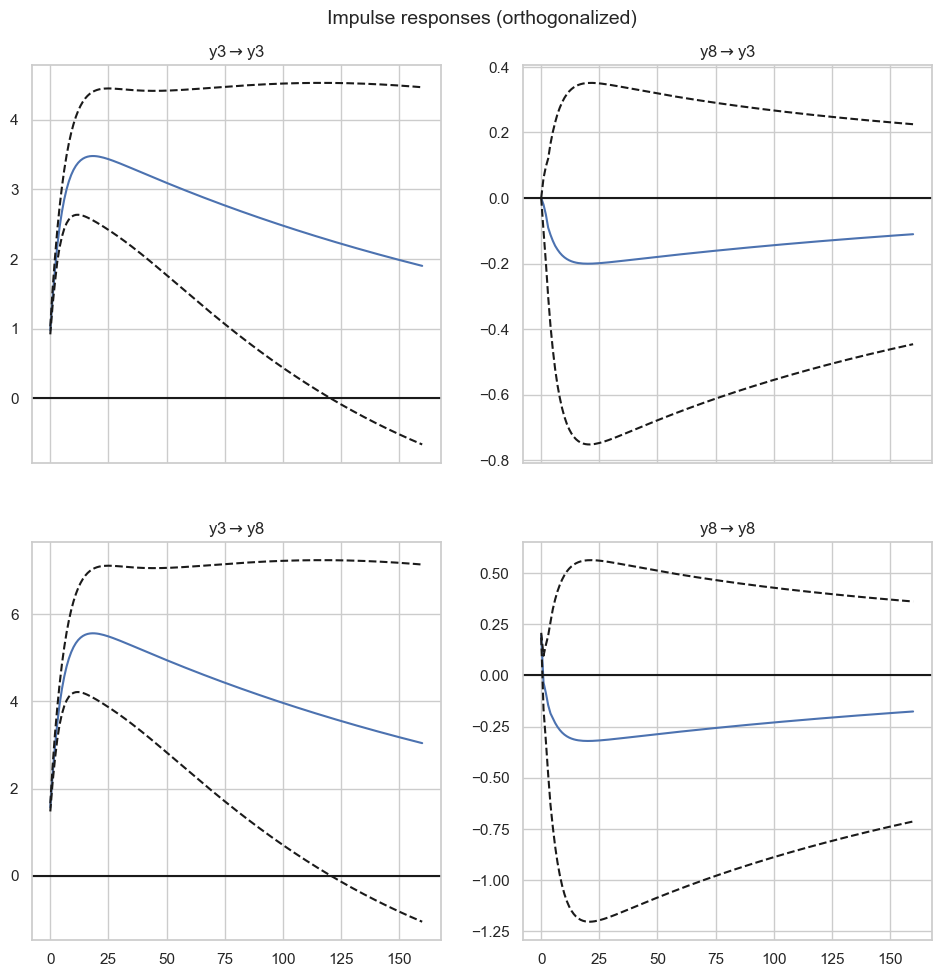

In [82]:
# Calculate and plot impulse response functions
irf = var_results.irf(160)  # 160 periods ahead
# and hence interpretations may change depending on variable ordering.
irf.plot(orth=True);

**Interpretation**

* y3->y3 : initial increase up to 25 days, and afterward slow decrease toward equilibrium
* y3->y8 : shock has bigger initial impact on y8, but as in previous case impacted variable is slowly converging toward 0
* y8->y3 : no first period impact of the y8 on y3. But we can observe negative impact on y3 and which converges back to 0
* y8->y8 : quick small jump at the beginning but as in previous case we are observing negative impact on first periods and convergence starting prior 25 period.




## Forecast Error Variance Decomposition ##

FEVD can help us to see what is the proportion of variance in error terms between each variable due to their own shock or shocks of other variable.

FEVD for y3
            y3        y8
0     1.000000  0.000000
1     0.999869  0.000131
2     0.999550  0.000450
3     0.999015  0.000985
4     0.998631  0.001369
5     0.998336  0.001664
6     0.998102  0.001898
7     0.997919  0.002081
8     0.997771  0.002229
9     0.997648  0.002352
10    0.997546  0.002454
11    0.997460  0.002540
12    0.997387  0.002613
13    0.997324  0.002676
14    0.997270  0.002730
15    0.997223  0.002777
16    0.997182  0.002818
17    0.997146  0.002854
18    0.997114  0.002886
19    0.997085  0.002915
20    0.997060  0.002940
21    0.997037  0.002963
22    0.997017  0.002983
23    0.996998  0.003002
24    0.996981  0.003019

FEVD for y8
            y3        y8
0     0.984632  0.015368
1     0.995006  0.004994
2     0.997188  0.002812
3     0.997643  0.002357
4     0.997685  0.002315
5     0.997667  0.002333
6     0.997604  0.002396
7     0.997529  0.002471
8     0.997456  0.002544
9     0.997386  0.002614
10    0.997323  0.002677
11    0.997267  0.002733


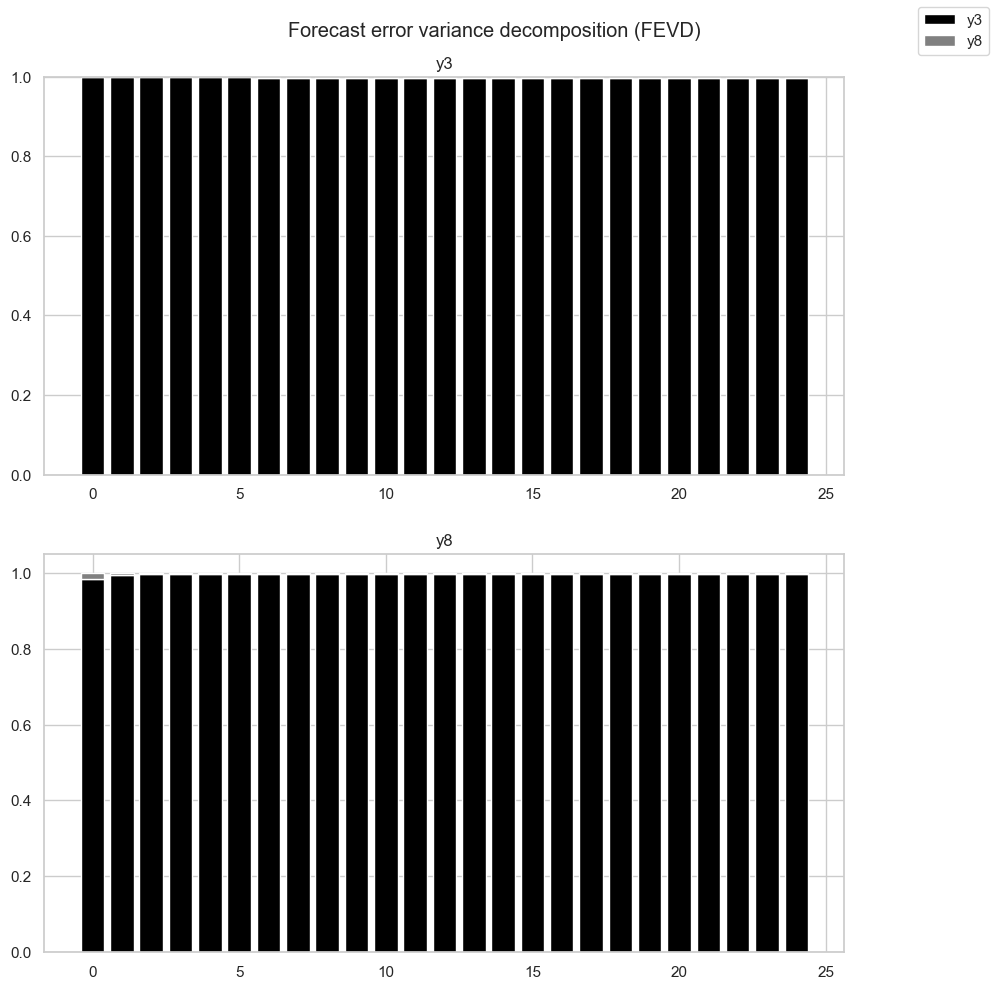

In [83]:
# Calculate and plot forecast error variance decomposition
fevd = var_results.fevd(25)  # 36 periods ahead
fevd.summary()

# Plot FEVD
var_results.fevd(25).plot();

We can see that variance of forecast error terms are explained mainly by changes in y3 for both variables. That confirms our main previous observations that shocks in y3 have impact on y8 but not other way around.

## Autocorrelation in residuals ##

In [84]:
residuals = var_results.resid

residuals = pd.DataFrame(residuals, columns=['y3', 'y8'])

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_y3 = acorr_ljungbox(residuals['y3'], lags=[10], return_df=True)
ljung_box_y8 = acorr_ljungbox(residuals['y8'], lags=[10], return_df=True)
print("y3 Residuals:\n", ljung_box_y3)
print("\ny8 Residuals:\n", ljung_box_y8)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_y3['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y3 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y3 residuals.")
if ljung_box_y8['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y8 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y8 residuals.")


Ljung-Box Test for Serial Correlation in Residuals (lag=10):
y3 Residuals:
          lb_stat    lb_pvalue
10 10.3488923152 0.4104352624

y8 Residuals:
          lb_stat    lb_pvalue
10 10.6796860287 0.3830117259

Conclusion at alpha=0.05:
 - Cannot reject H0 (no serial correlation) for y3 residuals.
 - Cannot reject H0 (no serial correlation) for y8 residuals.


Test indicate that there is no significant autocorrelation in residuals of chosen VAR model with 10 lags.
Let's examine how relation between residuals looks on diagram:

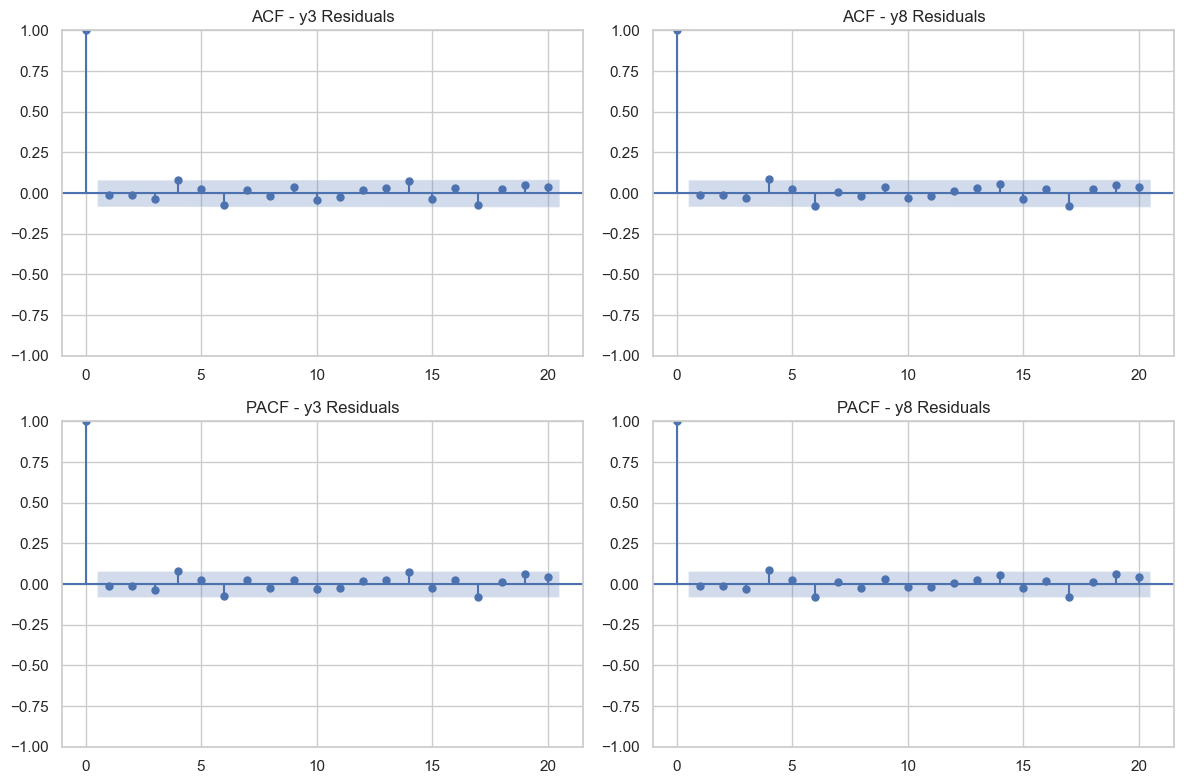

In [85]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals['y3'], ax=axes[0, 0], title='ACF - y3 Residuals', lags=20)
plot_pacf(residuals['y3'], ax=axes[1, 0], title='PACF - y3 Residuals', lags=20,
          method='ywm')  # 'ols' method might fail if near non-stationarity
plot_acf(residuals['y8'], ax=axes[0, 1], title='ACF - y8 Residuals', lags=20)
plot_pacf(residuals['y8'], ax=axes[1, 1], title='PACF - y8 Residuals', lags=20, method='ywm')
plt.tight_layout()
plt.show()

ACF and PACF for both variables shows that there might be some autocorrelation in 4th 6th and 17th lags.

Let's see how those would look like if we would add upt to 6th lag to our model.

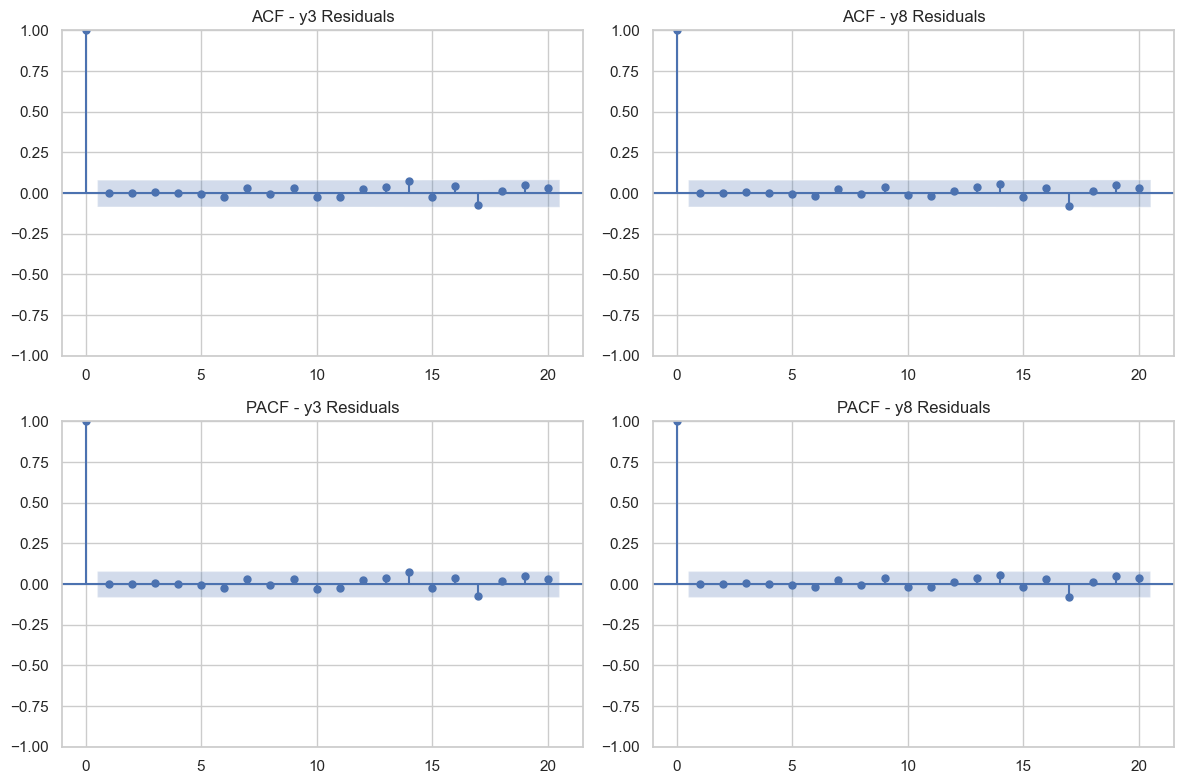

In [91]:
var_model_6 = VAR(coint_df, freq='D')
var_results_6 = var_model_6.fit(7)
resid_6 = var_results_6.resid

resid_6 = pd.DataFrame(resid_6, columns=['y3', 'y8'])

# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(resid_6['y3'], ax=axes[0, 0], title='ACF - y3 Residuals', lags=20)
plot_pacf(resid_6['y3'], ax=axes[1, 0], title='PACF - y3 Residuals', lags=20,
          method='ywm')  # 'ols' method might fail if near non-stationarity
plot_acf(resid_6['y8'], ax=axes[0, 1], title='ACF - y8 Residuals', lags=20)
plot_pacf(resid_6['y8'], ax=axes[1, 1], title='PACF - y8 Residuals', lags=20, method='ywm')
plt.tight_layout()
plt.show()

Incorporating more lags we removed autocorrelation between residuals. But given that the difference doesn't look that significant we won't respecify our previous model.

**Proceeding to checking normality of residuals:**

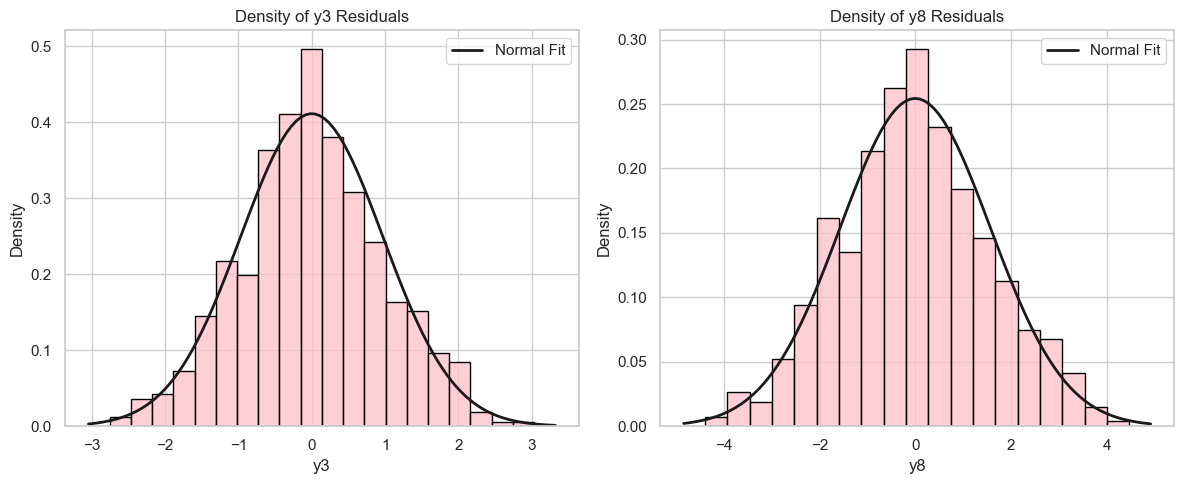

In [69]:
# Plot histograms of residuals with normal density overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals['y3'], kde=False, stat='density', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Density of y3 Residuals')
# Overlay normal distribution
mu_y3, std_y3 = residuals['y3'].mean(), residuals['y3'].std()
xmin_y3, xmax_y3 = axes[0].get_xlim()
x_y3 = np.linspace(xmin_y3, xmax_y3, 100)
p_y3 = norm.pdf(x_y3, mu_y3, std_y3)
axes[0].plot(x_y3, p_y3, 'k', linewidth=2, label='Normal Fit')
axes[0].legend()

sns.histplot(residuals['y8'], kde=False, stat='density', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Density of y8 Residuals')
# Overlay normal distribution
mu_y8, std_y8 = residuals['y8'].mean(), residuals['y8'].std()
xmin_y8, xmax_y8 = axes[1].get_xlim()
x_y8 = np.linspace(xmin_y8, xmax_y8, 100)
p_y8 = norm.pdf(x_y8, mu_y8, std_y8)
axes[1].plot(x_y8, p_y8, 'k', linewidth=2, label='Normal Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

Distribution is only a little bit denser in the middle, but we don't see huge tails or other characteristics of non-normal distribution. We will examine normality of distributions by running Jarque-Bera tests.

In [70]:
# Test for normality (Jarque-Bera test)
jb_y3_stat, jb_y3_pval, _, _ = jarque_bera(residuals['y3'])
jb_y8_stat, jb_y8_pval, _, _ = jarque_bera(residuals['y8'])

print("\nJarque-Bera Normality Test for Residuals:")
print(f"y3 Residuals: Statistic={jb_y3_stat:.3f}, p-value={jb_y3_pval:.3f}")
print(f"y8 Residuals: Statistic={jb_y8_stat:.3f}, p-value={jb_y8_pval:.3f}")

alpha_norm = 0.05
print(f"\nConclusion at alpha={alpha_norm}:")
if jb_y3_pval < alpha_norm:
    print(" - Reject normality for y3 residuals.")
else:
    print(" - Cannot reject normality for y3 residuals.")
if jb_y8_pval < alpha_norm:
    print(" - Reject normality for y8 residuals.")
else:
    print(" - Cannot reject normality for y8 residuals.")

# Multivariate Normality Test (using VECMResults method)
try:
    normality_test_results = vecm_results.test_normality()
    print("\nMultivariate Normality Test Results (using VECMResults method):")
    print(normality_test_results)
except Exception as e:
    print(f"\nCould not run multivariate normality test directly: {e}")


Jarque-Bera Normality Test for Residuals:
y3 Residuals: Statistic=0.396, p-value=0.820
y8 Residuals: Statistic=0.859, p-value=0.651

Conclusion at alpha=0.05:
 - Cannot reject normality for y3 residuals.
 - Cannot reject normality for y8 residuals.

Multivariate Normality Test Results (using VECMResults method):
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 0.573, critical value: 9.488>, p-value: 0.966>


There is not enough evidence to reject the H0 saying that distributions are normal.

## Forecasting using VECM ##

We are going to calculate forecast for the next 25 periods using VECM model. We alraedy have data divided into sample (575 observations) and test (25 observations) sets. Because we conducted all of previous operations on in sample data already, we can proceed directly to forecasting.

In [71]:
forecast_periods = 25
# We want both point forecast and most probable range (within 95 % confidence interval)
forecast_values = vecm_results.predict(steps=forecast_periods, alpha=0.05)
# Creating dataframe with all data for further research
forecast_df = pd.DataFrame(forecast_values[0], index=coint_test_df.index,
                           columns=['y3_fore', 'y8_fore'])
lower_df = pd.DataFrame(forecast_values[1], index=coint_test_df.index,
                           columns=['y3_lower', 'y8_lower'])
upper_df = pd.DataFrame(forecast_values[2], index=coint_test_df.index,
                           columns=['y3_upper', 'y8_upper'])

# Combine forecasts and intervals
forecast_merged= pd.concat([forecast_df, lower_df, upper_df], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_merged)


Forecasts and Confidence Intervals:
                 y3_fore       y8_fore      y3_lower      y8_lower  \
date                                                                 
2025-04-06 83.2299242137 62.5299657927 81.3522083286 59.4918911366   
2025-04-07 83.6013305264 63.1467250351 80.2417845932 57.7424266770   
2025-04-08 83.8030157138 63.4452256202 78.9361340450 55.6081945579   
2025-04-09 84.1147261336 63.9712397110 77.7278605087 53.7152025000   
2025-04-10 84.4598079751 64.5255953444 76.4777148300 51.7172791514   
2025-04-11 84.8408472115 65.0726186512 75.2504988221 49.6911154142   
2025-04-12 85.1309724202 65.5365789088 74.0191140399 47.7210921804   
2025-04-13 85.2325752729 65.7198762879 72.6369977858 45.5503551626   
2025-04-14 85.2879370268 65.8068241208 71.2608944612 43.3526941917   
2025-04-15 85.3524819524 65.9141648387 69.9440154058 41.2518134087   
2025-04-16 85.4090923817 66.0063831841 68.6748411559 39.2259222454   
2025-04-17 85.4559026965 66.0813616209 67.4425116355 

Now let's combine forecast with original data and present results on diagram.

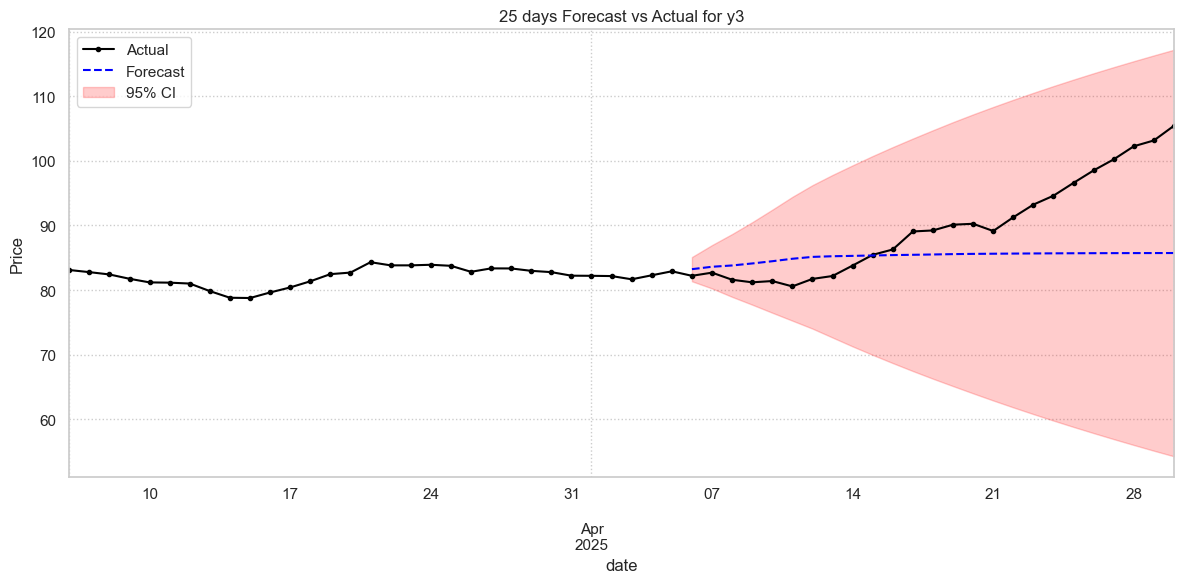

In [72]:
# Merge forecasts with the original data for plotting
df_merged = df_original.merge(forecast_merged, left_index=True, right_index=True, how='left')
utils.plot_forecast_with_ci('2025-03-06',df_merged,'y3','y3_fore','y3_lower','y3_upper','25 days Forecast vs Actual for y3','Price')

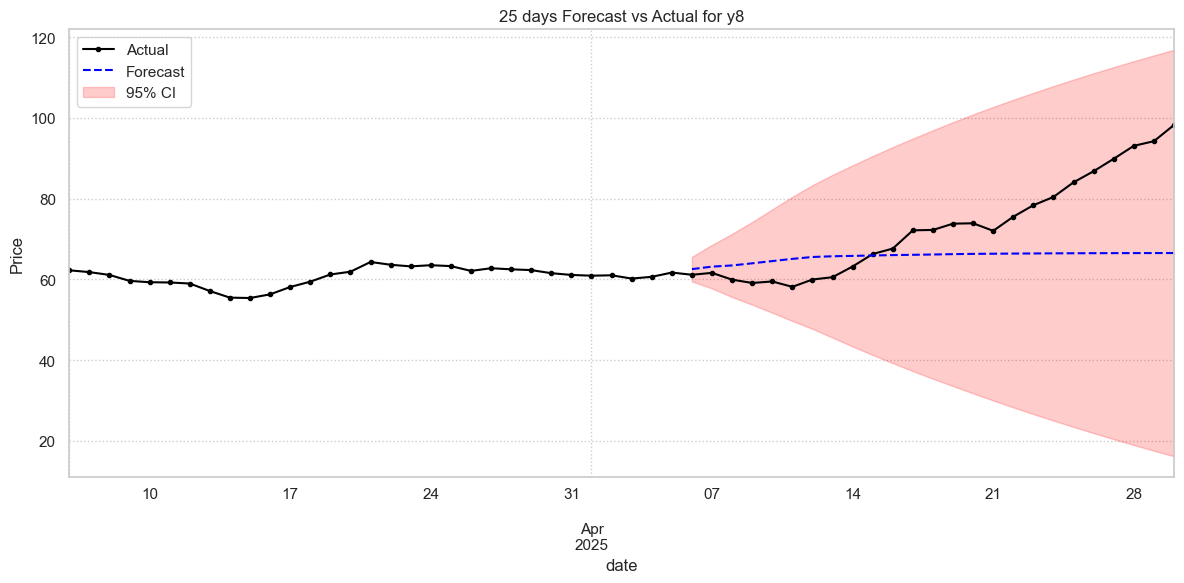

In [73]:
# Merge forecasts with the original data for plotting
# df_merged = df_original.merge(forecast_df, left_index=True, right_index=True, how='left')
utils.plot_forecast_with_ci('2025-03-06',df_merged,'y8','y8_fore','y8_lower','y8_upper','25 days Forecast vs Actual for y8','Price')

Forecast is not close to the real prices of assets in neither of those cases. Actual values are within our 95% confidence interval though.
In following section we will examine metrics for our out-of-sample period forecast errors.

## Ex-post forecast errors ##

In [94]:
utils.print_accuracy_measures(df_merged.dropna(),4,'y3','y8')

Forecast Accuracy Metrics for 4 lags:
                     y3             y8
MAE        6.3016085407  10.1636869930
MSE       71.1656804436 183.0599328975
RMSE       8.4359753700  13.5299642608
MAPE (%)   6.6110704537  12.5967636318
AMAPE (%)  6.9579044662  13.7554136568
